In [1]:
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

In [61]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.stats import linregress
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list

In [4]:
from echidna.utils import *

/Users/mingxuanzhang/anaconda3/envs/work3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [93]:
def pred_posterior_check(
    X_learned: np.ndarray,
    X_true: np.ndarray,
    name: str = "",
    log_scale: bool = False,
    R_val=True,
    equal_line=True,
    save: bool = True,
    color: str = None,
    title: str = "Predictive Posterior Check",
    xlabname: str = "True ",
    ylabname: str = "Simulated "
):
    """
    Plots lambda vs X.
    """
    # Subsample for plotting
    num = min(len(X_learned.flatten()), 200000)
    indx = np.random.choice(np.arange(len(X_learned.flatten())), num, replace=False)
    X_learned = X_learned.flatten()[indx]
    X_true = X_true.flatten()[indx]

    if log_scale:
        X_learned = np.log(X_learned + 1)
        X_true = np.log(X_true + 1)
        lbl_pstfix = "[log(x + 1)] "
    else:
        lbl_pstfix = ""

    x = X_true
    y = X_learned

    # Perform linear regression
    if R_val:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        r2 = r_value**2
        y_pred = slope * x + intercept

    maximum = max(np.max(x), np.max(y))
    minimum = min(np.min(x), np.min(y))

    # Scatter plot
    plt.scatter(x, y, alpha=0.1, label='Data points', color=color)
    if equal_line:
        plt.plot([minimum, maximum], [minimum, maximum], "r", label="x=y")
    
    # Plot the regression line
    if R_val:
        plt.plot(x, y_pred, label="Regression line", color='blue')

    plt.xlabel(xlabname + lbl_pstfix)
    plt.ylabel(ylabname + lbl_pstfix)
    
    # Annotate the plot with the R^2 value
    if R_val:
        plt.text(0.05, 0.95, f'$R^2$ = {r2:.2f}', ha='left', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.legend()
    plt.title(title + " " + name)
    
    if save:
        plt.savefig(f'{name}_posterior_predictive_check.png')
    
    plt.show()

In [97]:
def compare_covariance_matrix(data1, data2):
    n = data1.shape[-1]
    df1 = pd.DataFrame(data1, columns=[f"Clst {i}" for i in range(n)], index=[f"Clst {i}" for i in range(n)])
    df2 = pd.DataFrame(data2, columns=[f"Clst {i}" for i in range(n)], index=[f"Clst {i}" for i in range(n)])

    # Perform hierarchical clustering on the first dataset
    linkage_rows = linkage(df1, method='average', metric='euclidean')
    linkage_cols = linkage(df1.T, method='average', metric='euclidean')

    # Get the order of the rows and columns
    row_order = leaves_list(linkage_rows)
    col_order = leaves_list(linkage_cols)

    # Reorder both datasets
    df1_ordered = df1.iloc[row_order, col_order]
    df2_ordered = df2.iloc[row_order, col_order]

    # Create a grid for the plots
    fig = plt.figure(figsize=(20, 10))

    # Define the axes for the first plot
    gs = fig.add_gridspec(3, 4, width_ratios=[0.05, 1, 0.05, 1], height_ratios=[0.2, 1, 0.05], wspace=0.1, hspace=0.1)
    ax_col_dendro1 = fig.add_subplot(gs[0, 1])
    ax_heatmap1 = fig.add_subplot(gs[1, 1])

    # Define the axes for the second plot
    ax_col_dendro2 = fig.add_subplot(gs[0, 3])
    ax_heatmap2 = fig.add_subplot(gs[1, 3])

    # Plot dendrogram for columns of the first dataset
    dendro_col1 = dendrogram(linkage_cols, ax=ax_col_dendro1, orientation='top', no_labels=True, color_threshold=0)
    ax_col_dendro1.set_xticks([])
    ax_col_dendro1.set_yticks([])
    ax_col_dendro1.set_title("Refitted Covariance")

    # Plot heatmap for the first dataset
    sns.heatmap(df1_ordered, ax=ax_heatmap1, cbar=False, xticklabels=False, yticklabels=True)

    # Plot dendrogram for columns of the second dataset
    dendro_col2 = dendrogram(linkage_cols, ax=ax_col_dendro2, orientation='top', no_labels=True, color_threshold=0)
    ax_col_dendro2.set_xticks([])
    ax_col_dendro2.set_yticks([])
    ax_col_dendro2.set_title("Original Covariance")

    # Plot heatmap for the second dataset
    sns.heatmap(df2_ordered, ax=ax_heatmap2, cbar=False, xticklabels=False, yticklabels=True)

    plt.tight_layout()
    plt.show()

In [5]:
import os

In [6]:
patient = 'R310'
PATH = "../../Data/echidna3/"
path = os.path.join(PATH, patient + ".h5ad")
print(path)

../../Data/echidna3/R310.h5ad


In [7]:
w_path = os.path.join(PATH, "all_cellranger_w.csv")
w_path

'../../Data/echidna3/all_cellranger_w.csv'

In [8]:
W = read_W(w_path)

In [9]:
X = sc.read_h5ad(path)

In [10]:
X_obs, W_obs, z_obs, pi_obs = prepare_input(X, W, sample_name=patient, 
                                            timepoints=['pre', 'on2'], n_subsamples=3000, device="cpu")
print(X_obs.shape)
print(W_obs.shape)
print(z_obs.shape)
print(pi_obs.shape)

torch.Size([2, 3000, 23648])
torch.Size([2, 23648])
torch.Size([2, 3000])
torch.Size([2, 10])


In [11]:
from echidna.model import Echidna
from echidna.train import train_Echidna
from echidna.utils import ModelConfig
from echidna.params import *
from echidna.eval import *

In [12]:
config = ModelConfig()
config.num_cells = X_obs.shape[1]
config.num_genes = X_obs.shape[-1]
config.num_timepoints = X_obs.shape[0]
config.num_clusters = pi_obs.shape[-1]
config.q_corr_init = 1e-2
config.q_shape_rate_scaler = 10.0
config.eta_mean_init = 2.0
config.eps = 5e-3

In [13]:
echidna = Echidna(config, mode="MT", device="cpu")
echidna, losses = train_Echidna(echidna, X_obs, W_obs, pi_obs, z_obs, lr=0.1, n_epochs=1000)

100%|██████████| 1000/1000 [08:33<00:00,  1.95it/s]


In [15]:
eta_ground_truth = eta_posterior_estimates(echidna, X_obs, W_obs, pi_obs, z_obs, num_samples=1000)
c_pre_ground_truth, c_on_ground_truth = c_posterior_estimates(eta=eta_ground_truth, mt=True)
cov_ground_truth = cov_posterior_estimate(inverse_gamma=False)

In [19]:
c_pre_ground_truth.shape

torch.Size([10, 23648])

# PPC of X and W

In [56]:
lib_on = X_obs[0, :, :].sum(-1, keepdim=True) * 1e-5
lib_pre = X_obs[1, :, :].sum(-1, keepdim=True) * 1e-5
z_on = z_obs[0, :]
z_pre = z_obs[1, :]
X_simulated_pre = sample_X(X_obs.numpy(), c_pre_ground_truth, eta_ground_truth, z_pre.numpy(), lib_pre)
X_simulated_on = sample_X(X_obs.numpy(), c_on_ground_truth, eta_ground_truth, z_on.numpy(), lib_on)

In [57]:
X_simulated = np.concatenate([X_simulated_on, X_simulated_pre])
X_simulated.shape

(6000, 23648)

In [58]:
W_simulated = np.array(sample_W(pi_obs, eta_ground_truth))

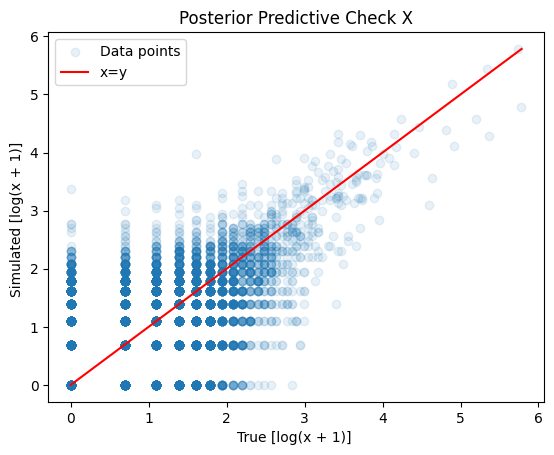

In [59]:
pred_posterior_check(X_simulated, X_obs.numpy(), log_scale=True, name='X', R_val=False)

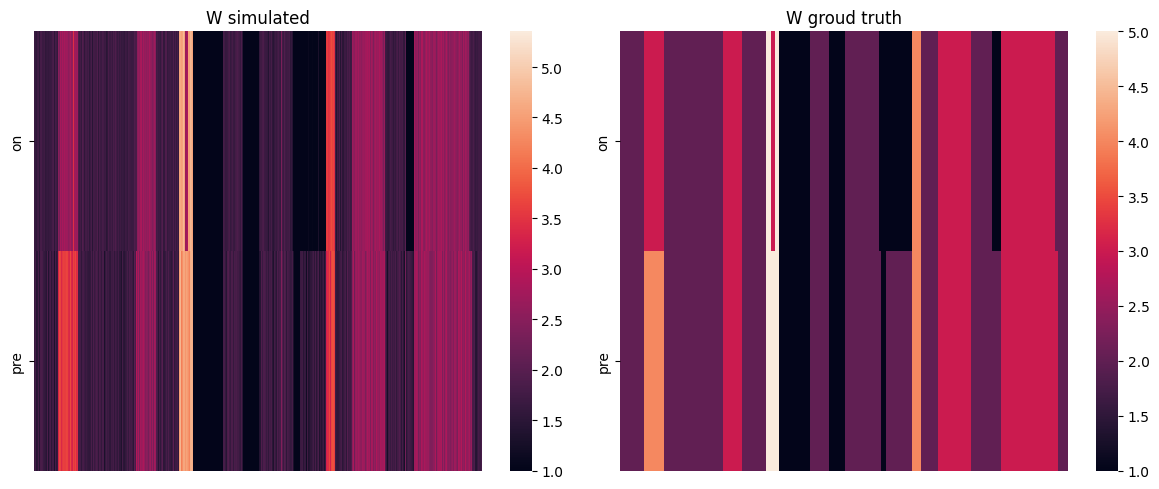

In [47]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first heatmap
sns.heatmap(W_simulated, ax=axes[0], vmin=1)
axes[0].set_title('W simulated')
axes[0].set_xticks([])
axes[0].set_yticklabels(['on', 'pre'])

# Plot the second heatmap
sns.heatmap(W_obs.numpy(), ax=axes[1])
axes[1].set_title("W groud truth")
axes[1].set_xticks([])
axes[1].set_yticklabels(['on', 'pre'])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Refit and Goodness-of-fit for c and eta

In [48]:
X_simulated = torch.tensor(X_simulated).reshape(2, 3000, 23648)
W_simulated = torch.tensor(W_simulated)

In [49]:
W_simulated.shape

torch.Size([2, 23648])

In [50]:
echidna = Echidna(config, mode="MT", device="cpu")
echidna, losses = train_Echidna(echidna, X_simulated, W_simulated, pi_obs, z_obs, lr=0.1, n_epochs=1000)

100%|██████████| 1000/1000 [08:35<00:00,  1.94it/s]


In [51]:
eta_fit = eta_posterior_estimates(echidna, X_simulated, W_simulated, pi_obs, z_obs, num_samples=1000)
c_pre_fit, c_on_fit = c_posterior_estimates(eta=eta_fit, mt=True)
cov_fit = cov_posterior_estimate(inverse_gamma=False)

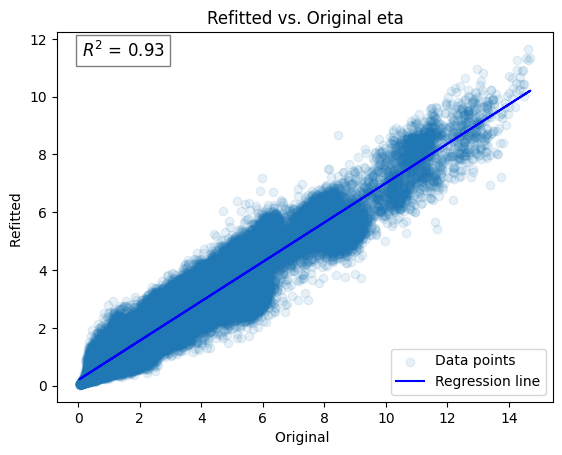

In [94]:
pred_posterior_check(np.array(eta_fit), np.array(eta_ground_truth), 
                     name='eta', log_scale=False, R_val=True, equal_line=False, save=False, 
                     title="Refitted vs. Original", xlabname="Original ", ylabname="Refitted ")

In [77]:
c_fit = torch.concatenate([c_on_fit, c_pre_fit])
c_gt = torch.concatenate([c_on_ground_truth, c_pre_ground_truth])

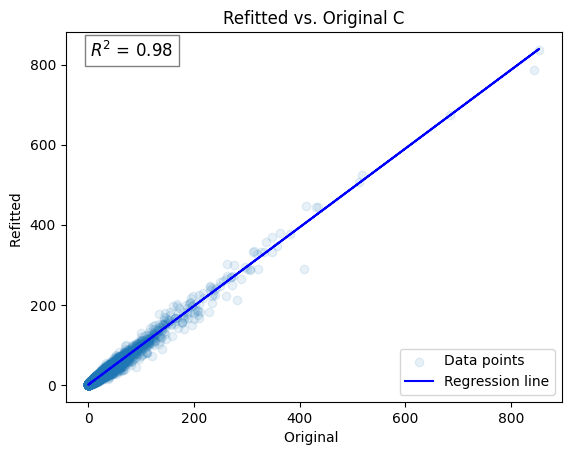

In [99]:
pred_posterior_check(np.array(c_fit), np.array(c_gt), 
                     name='C', log_scale=False, R_val=True, equal_line=False, save=False, 
                     title="Refitted vs. Original", xlabname="Original ", ylabname="Refitted ")

/var/folders/n0/lbm2yq4n3r1gp83zkf5s69j00000gn/T/ipykernel_12941/3801177684.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


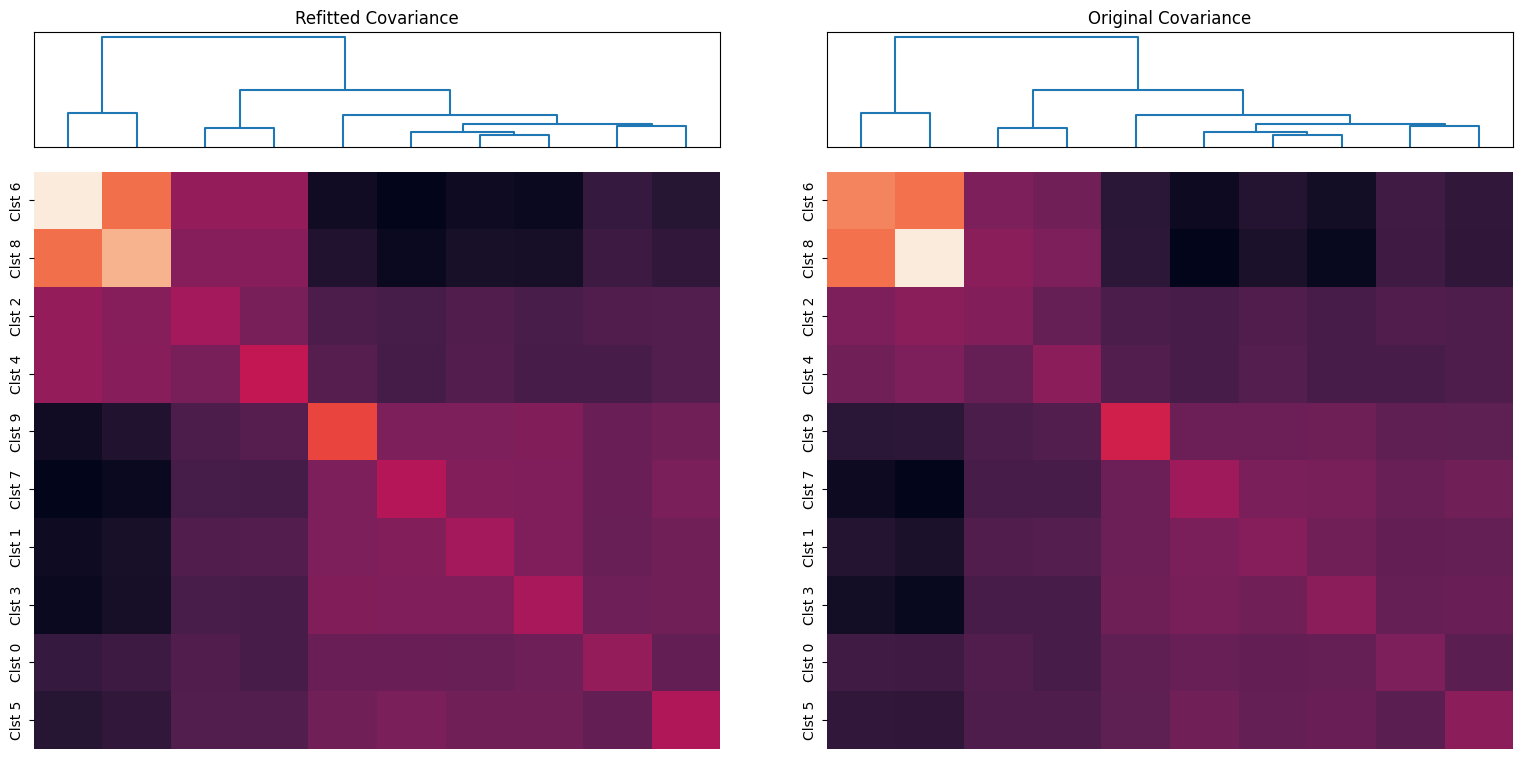

In [98]:
compare_covariance_matrix(cov_fit, cov_ground_truth)